## **Use the EfficientNetB0 model, use the clean data for training and validation, and use the clean and polluted data for testing. Finally, generate the GradCAM map.**

# **Authorize Drive and set up pre-environments**

In [1]:
# Mount and authorize Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Make sure the necessary packages are installed
!pip install --quiet --upgrade torch torchvision matplotlib seaborn scikit-learn tqdm pillow grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 82.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.2/865.2 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 115.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.5 MB/s eta 

In [3]:
# Loading Kit
import random
import os
import shutil
import time
from PIL import Image
import pandas as pd
import numpy as np
import torch
from torchvision import transforms as tfs
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset,DataLoader
from torchvision import transforms
from torch.utils.data import random_split
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import models
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score, f1_score,accuracy_score,precision_score,confusion_matrix,classification_report, top_k_accuracy_score
import torch.nn.functional as F
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

In [4]:
# Setting up training equipment
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# **Building a dataset**

In [31]:
# Unzip Aerial_Landscapes.zip
import zipfile
import os

# Path to the compressed file
zip_path = '/content/drive/MyDrive/Aerial_Landscapes.zip'
extract_path = '/content/aerial_data'

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipping complete!")


Unzipping complete!


In [32]:
# Split into train / val / test folders
import shutil
from sklearn.model_selection import train_test_split

# Assume that the folder after decompression is extract_path, which contains the folders of each type of image
source_dir = os.path.join(extract_path, 'Aerial_Landscapes')
split_root = '/content/split_data'

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]

    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, split_imgs in zip(['train', 'val', 'test'], [train_imgs, val_imgs, test_imgs]):
        split_dir = os.path.join(split_root, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(split_dir, img))

print("Dataset splitting completed！")

Dataset splitting completed！


In [33]:
# Read the data set and create a data table
def create_df(root):
    label = 0
    label_list = []
    filepath_list = []
    class_list = []

    for class_name in sorted(os.listdir(root)):
        class_path = os.path.join(root, class_name)
        if not os.path.isdir(class_path):
            continue

        for filename in os.listdir(class_path):
            image_path = os.path.join(class_path, filename)
            filepath_list.append(image_path)
            class_list.append(class_name)
            label_list.append(label)
        label += 1

    return pd.DataFrame({
        "filename": filepath_list,
        "class": class_list,
        "label": label_list
    })

df_train = create_df('/content/split_data/train')
df_val = create_df('/content/split_data/val')
df_test = create_df('/content/split_data/test')

print("Create df successfully！")
df_train.head()


Create df successfully！


,filename,class,label
0,/content/split_data/train/Agriculture/163.jpg,Agriculture,0
1,/content/split_data/train/Agriculture/186.jpg,Agriculture,0
2,/content/split_data/train/Agriculture/415.jpg,Agriculture,0
3,/content/split_data/train/Agriculture/334.jpg,Agriculture,0
4,/content/split_data/train/Agriculture/784.jpg,Agriculture,0


In [34]:
# Define image preprocessing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize = transforms.Normalize(mean, std)

resize_H, resized_W = 224,224
resize = transforms.Resize([resize_H, resized_W])

transformations_train = transforms.Compose([resize,
                                    tfs.RandomHorizontalFlip(0.2),
                                    tfs.ColorJitter(brightness=0.5, contrast=0.5, hue=0.5),
                                    transforms.ToTensor(),
                                    transforms.RandomAffine(0, None, (0.7, 1.1), (0, 30),fill=(127,127,127)),
                                    normalize])
transformations_test = transforms.Compose([resize,
                                    transforms.ToTensor(),
                                    normalize])

In [48]:
# Convert image to Tensor
from torch.utils.data import Dataset
from PIL import Image
from torchvision import datasets
import torchvision.transforms as T
from torchvision import datasets

tmp_dataset = datasets.ImageFolder(root="aerial_data/Aerial_Landscapes")
class_names = tmp_dataset.classes

df_train["class"] = df_train["label"].apply(lambda x: class_names[x])
df_val["class"] = df_val["label"].apply(lambda x: class_names[x])
df_test["class"] = df_test["label"].apply(lambda x: class_names[x])

# Training configuration
batch_size = 32
num_workers = 2

class PollutedImageDataset(Dataset):
    def __init__(self, dataframe, transform=None, pollution_map=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform
        self.pollution_map = pollution_map or {}

    def apply_pollution(self, img_tensor, class_name):
        for mode, class_list in self.pollution_map.items():
            if class_name in class_list:
                if mode == "GaussianNoise":
                    noise = torch.randn_like(img_tensor) * 0.1
                    return torch.clamp(img_tensor + noise, 0., 1.)
                elif mode == "Cutout":
                    x = img_tensor.clone()
                    _, h, w = x.shape
                    cutout_size = h // 3
                    y0 = random.randint(0, h - cutout_size)
                    x0 = random.randint(0, w - cutout_size)
                    x[:, y0:y0+cutout_size, x0:x0+cutout_size] = 0.
                    return x
                elif mode == "GaussianBlur":
                    blur = T.GaussianBlur(kernel_size=5)
                    return blur(img_tensor)
        return img_tensor

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]
        class_name = self.df.loc[idx, "class"]

        image = Image.open(img_path).convert("RGB")
        img_tensor = self.transform(image)
        polluted_tensor = self.apply_pollution(img_tensor, class_name)

        return polluted_tensor, label

    def __len__(self):
        return len(self.df)

class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, "path"]
        label = self.df.loc[idx, "label"]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.df)

pollution_map = {
    "GaussianNoise": ["Agriculture", "Airport", "Beach", "City"],
    "Cutout": ["Desert", "Forest", "Grassland", "Highway"],
    "GaussianBlur": ["Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"]
}

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

# The training data uses the polluted version of Dataset
train_dataset = ImageDataset(df_train, transformations_train)

# Keep verification and test data clean
test_dataset = ImageDataset(df_test, transformations_test)
val_dataset = ImageDataset(df_val, transformations_test)
testpol_dataset = PollutedImageDataset(df_test, transform=train_transform, pollution_map=pollution_map)

# Creating a Data Loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testpol_loader = DataLoader(testpol_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# **Efficientnet_b0**

In [50]:
def load_split_dataframe(img_folder, test_size=0.2, val_size=0.2, random_state=42):
    dataset = datasets.ImageFolder(img_folder)
    class_names = dataset.classes

    df_all = pd.DataFrame({
        "path": [s[0] for s in dataset.samples],
        "label": [s[1] for s in dataset.samples],
    })
    df_all["class"] = df_all["label"].apply(lambda x: class_names[x])

    df_train, df_test = train_test_split(df_all, test_size=test_size, stratify=df_all["label"], random_state=random_state)
    df_train, df_val = train_test_split(df_train, test_size=val_size, stratify=df_train["label"], random_state=random_state)

    return df_train.reset_index(drop=True), df_val.reset_index(drop=True), df_test.reset_index(drop=True), class_names

df_train, df_val, df_test, class_names = load_split_dataframe("aerial_data/Aerial_Landscapes")
print("df_train columns:", df_train.columns.tolist())
print(df_train.head(2))

df_train columns: ['path', 'label', 'class']
                                                path  label        class
0         aerial_data/Aerial_Landscapes/Port/022.jpg     11         Port
1  aerial_data/Aerial_Landscapes/Residential/249.jpg     13  Residential


In [30]:
# Model 2: EfficientNet-B0
net = models.efficientnet_b0(pretrained=True)

net.classifier[1] = nn.Linear(net.classifier[1].in_features, 15)


net.to(device)

criterion = nn.CrossEntropyLoss()
my_lr = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=my_lr)

epochs = 10

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

for epoch in range(epochs):
    net.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = net(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == target).sum().item()
        total_train += target.size(0)

    train_loss_epoch = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train
    train_loss.append(train_loss_epoch)
    train_acc.append(train_accuracy)


    net.eval()
    all_preds = []
    all_labels = []
    running_valid_loss = 0.0
    correct_valid = 0
    total_valid = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            outputs = net(data)
            loss = criterion(outputs, target)

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            running_valid_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_valid += (predicted == target).sum().item()
            total_valid += target.size(0)

    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    valid_loss_epoch = running_valid_loss / len(val_loader)
    valid_accuracy = correct_valid / total_valid
    valid_loss.append(valid_loss_epoch)
    valid_acc.append(valid_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss_epoch:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Valid Loss: {valid_loss_epoch:.4f}, Valid Accuracy: {valid_accuracy:.4f}, "
          f"Recall: {recall:.4f}, F1-score: {f1:.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Train Loss: 2.0867, Train Accuracy: 0.3275, Valid Loss: 1.2174, Valid Accuracy: 0.6203, Recall: 0.6203, F1-score: 0.6052
Epoch [2/10], Train Loss: 1.2014, Train Accuracy: 0.6100, Valid Loss: 0.6724, Valid Accuracy: 0.7917, Recall: 0.7917, F1-score: 0.7927
Epoch [3/10], Train Loss: 0.8536, Train Accuracy: 0.7250, Valid Loss: 0.6118, Valid Accuracy: 0.8109, Recall: 0.8109, F1-score: 0.8112
Epoch [4/10], Train Loss: 0.6855, Train Accuracy: 0.7801, Valid Loss: 0.4820, Valid Accuracy: 0.8500, Recall: 0.8500, F1-score: 0.8504
Epoch [5/10], Train Loss: 0.5558, Train Accuracy: 0.8207, Valid Loss: 0.3966, Valid Accuracy: 0.8651, Recall: 0.8651, F1-score: 0.8616
Epoch [6/10], Train Loss: 0.4719, Train Accuracy: 0.8497, Valid Loss: 0.5248, Valid Accuracy: 0.8229, Recall: 0.8229, F1-score: 0.8210
Epoch [7/10], Train Loss: 0.4071, Train Accuracy: 0.8665, Valid Loss: 0.2956, Valid Accuracy: 0.8990, Recall: 0.8990, F1-score: 0.8991
Epoch [8/10], Train Loss: 0.3384, Train Accuracy: 0.892


🧪 Test Results
Test Loss: 0.2341
Test Accuracy: 0.9204
Test Recall: 0.9204
Test F1-score: 0.9204
Top-5 Accuracy: 0.9971
⏱️ Test Time: 10.04 seconds
📦 Model Size: 15.65 MB

📊 Confusion Matrix:
[[150   0   0   0   1   1   5   0   0   2   0   1   0   0   0]
 [  0 141   0   1   1   0   0   4   1   2   0   0  10   0   0]
 [  0   0 156   0   0   0   0   0   2   0   0   1   1   0   0]
 [  0   1   0 140   0   0   0   0   0   6   1   3   7   2   0]
 [  0   1   5   0 141   0   0   0   0  13   0   0   0   0   0]
 [  0   0   2   0   4 118  35   0   0   1   0   0   0   0   0]
 [  1   0   0   0   4   0 153   0   2   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0 153   0   1   0   0   3   0   2]
 [  1   1   2   0   1   0   0   0 153   0   0   0   0   0   2]
 [  0   0   1   0   2   0   3   0   1 152   0   0   0   0   1]
 [  0   3   0   0   0   0   0   1   0   0 153   0   2   1   0]
 [  0   1   0   0   0   0   0   0   1   0   2 154   2   0   0]
 [  0   4   0   0   0   0   0   2   0   0   0   0 1

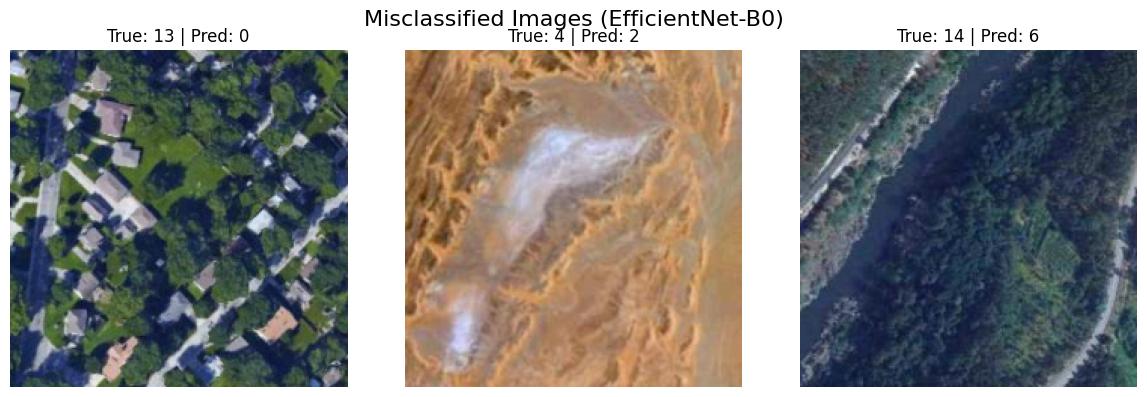

In [51]:
# Test model (EfficientNet-B0)- clean data
# Set the model to evaluation mode
net.eval()

all_preds = []
all_labels = []
all_probs = []
running_test_loss = 0.0
correct_test = 0
total_test = 0
misclassified_images = []

start_time = time.time()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        loss = criterion(outputs, target)

        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())

        # Finding misjudgments
        for i in range(len(data)):
            if preds[i] != target[i]:
                misclassified_images.append({
                    "index": batch_idx * test_loader.batch_size + i,
                    "true": int(target[i].cpu()),
                    "pred": int(preds[i].cpu())
                })

        running_test_loss += loss.item()
        correct_test += (preds == target).sum().item()
        total_test += target.size(0)

end_time = time.time()
elapsed_time = end_time - start_time

# ---------
# Indicator calculation
# ---------
test_loss = running_test_loss / len(test_loader)
test_accuracy = correct_test / total_test
test_recall = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Top-5 Accuracy（Optional)
top5_acc = top_k_accuracy_score(all_labels, np.array(all_probs), k=5)

# Model size (after storage)
model_path = "efficientnet_b0_test.pt"
torch.save(net.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, digits=4)

# ---------
# Output
# ---------
print(f"\n🧪 Test Results")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"⏱️ Test Time: {elapsed_time:.2f} seconds")
print(f"📦 Model Size: {model_size_mb:.2f} MB")
print(f"\n📊 Confusion Matrix:\n{cm}")
print(f"\n📃 Classification Report:\n{report}")

print(f"\n❌ Total Misclassified Images: {len(misclassified_images)}")
for i, item in enumerate(misclassified_images[:10]):  # Only print the first 10 false positive samples
    print(f"[{i}] Index: {item['index']}, True: {item['true']}, Pred: {item['pred']}")

# ---------- Store misjudged images ----------
save_dir = "efficientnet_misclassified"
os.makedirs(save_dir, exist_ok=True)

# ---------- Draw the first n misjudged images ----------
def plot_misclassified_images(n=9):
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    fig.suptitle("Misclassified Images (EfficientNet-B0)", fontsize=16)

    shown = 0
    for i, item in enumerate(misclassified_images):
        if shown >= n:
            break

        batch_idx = item['index'] // test_loader.batch_size
        local_idx = item['index'] % test_loader.batch_size

        data_batch, target_batch = list(test_loader)[batch_idx]
        img = data_batch[local_idx]

        ax = axes[shown]
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"True: {item['true']} | Pred: {item['pred']}")
        shown += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Drawing
plot_misclassified_images(n=3)

In [52]:
efficientnet_test_results = {
    'name': 'EfficientNetB0',
    'accuracy': test_accuracy,
    'recall': test_recall,
    'f1': test_f1,
    'loss': test_loss,
    'top5_accuracy': top5_acc,
    'test_time_sec': elapsed_time,
    'model_size_MB': model_size_mb,
    'misclassified_count': len(misclassified_images)
}


🧪 Test Results
Test Loss: 1.5646
Test Accuracy: 0.6279
Test Recall: 0.6279
Test F1-score: 0.6071
Top-5 Accuracy: 0.9263
⏱️ Test Time: 13.47 seconds
📦 Model Size: 15.65 MB

📊 Confusion Matrix:
[[ 80   2   0   0  54   0   8   0   5   1   5   3   2   0   0]
 [  1 107   1   0  11   0   1   0   0   1   0  29   9   0   0]
 [  2   6  97   0  19   0   0   0   2   0   0  31   0   0   3]
 [  1  27   1   7  10   0   0   0   0   5  21  82   6   0   0]
 [ 11   1   1   0  29   0   0   0 113   1   0   2   2   0   0]
 [  0   0   0   0   0  33   4   0 122   0   0   0   1   0   0]
 [ 10   0   0   0   0   0  23   0 127   0   0   0   0   0   0]
 [  3   5   0   0   0   0   0 111  12   0   0   0  27   0   2]
 [  4   0   3   0   2   0   0   0 149   0   0   0   0   0   2]
 [  0   0   1   0   7   0   3   0   1 147   0   0   0   0   1]
 [  0  10   1   1   0   0   2   2   0   0 141   0   2   1   0]
 [  0   0   2   0   0   0   0   0   3   0   2 150   2   0   1]
 [  0   7   0   0   0   0   0   5   0   0   0   0 1

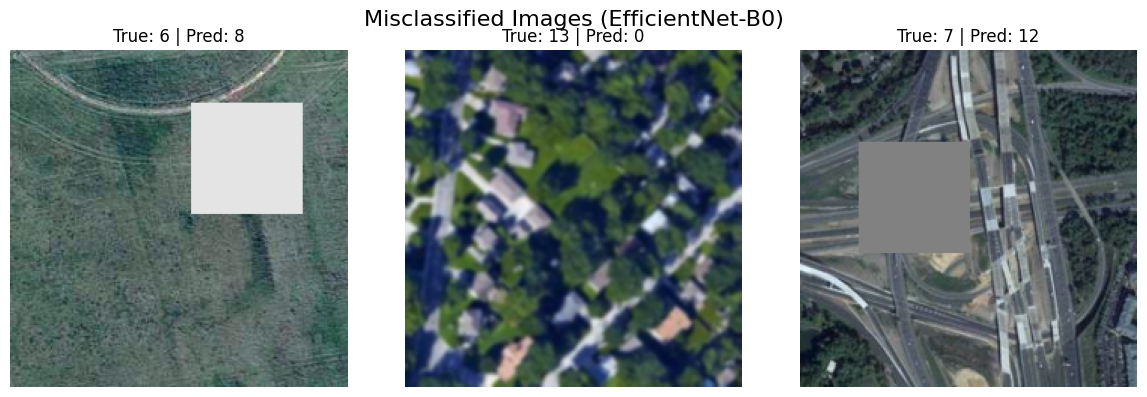

In [53]:
# Test model (EfficientNet-B0) -polluted data
# Set the model to evaluation mode
net.eval()

all_preds = []
all_labels = []
all_probs = []
running_test_loss = 0.0
correct_test = 0
total_test = 0
misclassified_images = []

start_time = time.time()

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(testpol_loader):
        data, target = data.to(device), target.to(device)
        outputs = net(data)
        loss = criterion(outputs, target)

        probs = F.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

        all_probs.extend(probs.cpu().numpy())

        # Finding misjudgments
        for i in range(len(data)):
            if preds[i] != target[i]:
                misclassified_images.append({
                    "index": batch_idx * testpol_loader.batch_size + i,
                    "true": int(target[i].cpu()),
                    "pred": int(preds[i].cpu())
                })

        running_test_loss += loss.item()
        correct_test += (preds == target).sum().item()
        total_test += target.size(0)

end_time = time.time()
elapsed_time = end_time - start_time

# ---------
# Indicator calculation
# ---------
test_loss = running_test_loss / len(testpol_loader)
test_accuracy = correct_test / total_test
test_recall = recall_score(all_labels, all_preds, average='macro')
test_f1 = f1_score(all_labels, all_preds, average='macro')

# Top-5 Accuracy（Optional)
top5_acc = top_k_accuracy_score(all_labels, np.array(all_probs), k=5)

# Model size (after storage)
model_path = "efficientnet_b0_test.pt"
torch.save(net.state_dict(), model_path)
model_size_mb = os.path.getsize(model_path) / (1024 * 1024)

# Confusion Matrix and Classification Report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, digits=4)

# ---------
# Output
# ---------
print(f"\n🧪 Test Results")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Top-5 Accuracy: {top5_acc:.4f}")
print(f"⏱️ Test Time: {elapsed_time:.2f} seconds")
print(f"📦 Model Size: {model_size_mb:.2f} MB")
print(f"\n📊 Confusion Matrix:\n{cm}")
print(f"\n📃 Classification Report:\n{report}")

print(f"\n❌ Total Misclassified Images: {len(misclassified_images)}")
for i, item in enumerate(misclassified_images[:10]):  # Only print the first 10 false positive samples
    print(f"[{i}] Index: {item['index']}, True: {item['true']}, Pred: {item['pred']}")

# ---------- Store misjudged images ----------
save_dir = "efficientnet_misclassified"
os.makedirs(save_dir, exist_ok=True)

# ---------- Draw the first n misjudged images ----------
def plot_misclassified_images(n=9):
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
    fig.suptitle("Misclassified Images (EfficientNet-B0)", fontsize=16)

    shown = 0
    for i, item in enumerate(misclassified_images):
        if shown >= n:
            break

        batch_idx = item['index'] // testpol_loader.batch_size
        local_idx = item['index'] % testpol_loader.batch_size

        data_batch, target_batch = list(testpol_loader)[batch_idx]
        img = data_batch[local_idx]

        ax = axes[shown]
        img_np = img.permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"True: {item['true']} | Pred: {item['pred']}")
        shown += 1

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()

# Drawing
plot_misclassified_images(n=3)



In [54]:
efficientnet_poltest_results = {
    'name': 'EfficientNetB0_pol',
    'accuracy': test_accuracy,
    'recall': test_recall,
    'f1': test_f1,
    'loss': test_loss,
    'top5_accuracy': top5_acc,
    'test_time_sec': elapsed_time,
    'model_size_MB': model_size_mb,
    'misclassified_count': len(misclassified_images)
}

#**Comparison data results**

In [59]:
# Comparison data results
# Integrate six test results
all_results = [
    efficientnet_poltest_results,
    efficientnet_test_results
]

results_df = pd.DataFrame(all_results)

# Display the form (make sure the fields are correct)
display(results_df)

# Normalize all indicators (for easy drawing together)
metrics = ['accuracy', 'recall', 'f1', 'loss', 'top5_accuracy', 'test_time_sec', 'model_size_MB', 'misclassified_count']

# Make a regularized copy (without affecting the original material)
scaled_df = results_df.copy()
scaler = MinMaxScaler()
scaled_df[metrics] = scaler.fit_transform(scaled_df[metrics])


,name,accuracy,recall,f1,loss,top5_accuracy,test_time_sec,model_size_MB,misclassified_count
0,EfficientNetB0_pol,0.627917,0.627917,0.607120,1.564576,0.926250,13.473243,15.650029,893
1,EfficientNetB0,0.920417,0.920417,0.920403,0.234136,0.997083,10.040785,15.650029,191


# **Grad-CAM**

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


==== Showing Grad-CAM under GaussianNoise ====


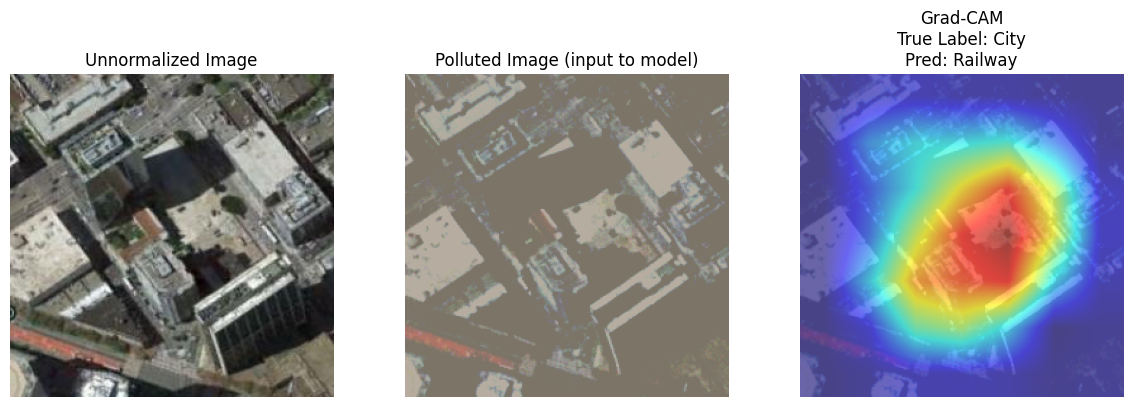

==== Showing Grad-CAM under Cutout ====


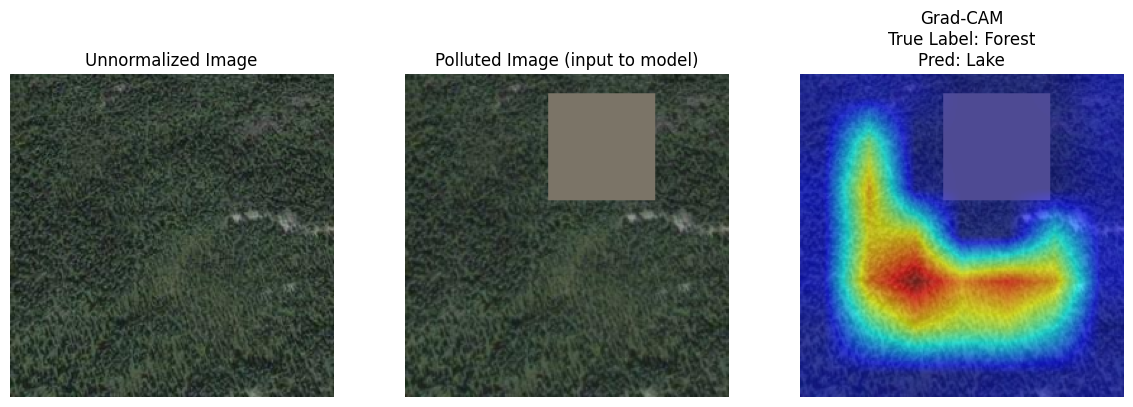

==== Showing Grad-CAM under GaussianBlur ====


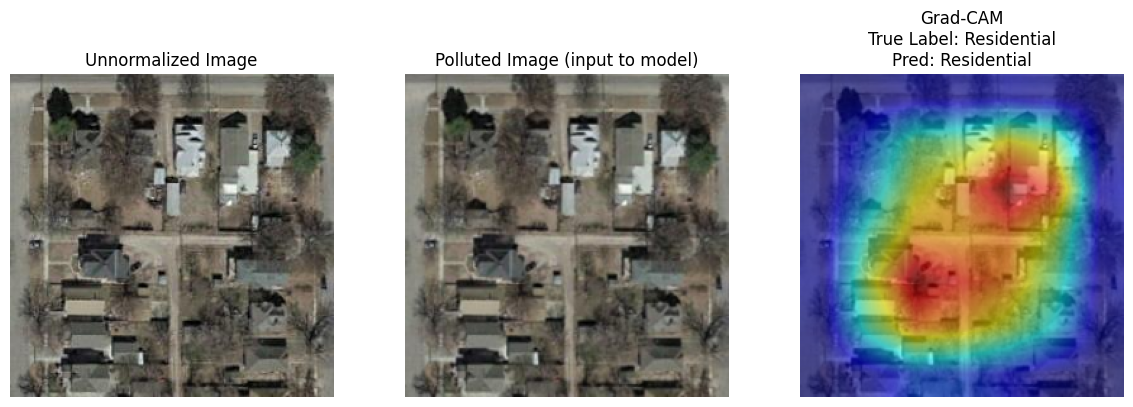

In [61]:
import os
import random
import torch
import torchvision.transforms as T
from torchvision import models
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Presets and Models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b0(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 15)
model.load_state_dict(torch.load("efficientnet_b0_test.pt", map_location=device))
model = model.to(device)
model.eval()

# Category correspondence (according to the order of folders)
class_names = sorted(os.listdir("aerial_data/Aerial_Landscapes"))
class_to_idx = {cls: i for i, cls in enumerate(class_names)}

# Preprocessing and denormalization
normalize = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])
unnormalize = lambda x: x * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)

# Pollution strategy classification
pollution_map = {
    "GaussianNoise": ["Agriculture", "Airport", "Beach", "City"],
    "Cutout": ["Desert", "Forest", "Grassland", "Highway"],
    "GaussianBlur": ["Lake", "Mountain", "Parking", "Port", "Railway", "Residential", "River"]
}

# Pollution Function
def apply_pollution(img_tensor, mode):
    if mode == "GaussianNoise":
        noise = torch.randn_like(img_tensor) * 0.1
        return torch.clamp(img_tensor + noise, 0., 1.)
    elif mode == "Cutout":
        x = img_tensor.clone()
        _, h, w = x.shape
        cutout_size = h // 3
        y0 = random.randint(0, h - cutout_size)
        x0 = random.randint(0, w - cutout_size)
        x[:, y0:y0+cutout_size, x0:x0+cutout_size] = 0.
        return x
    elif mode == "GaussianBlur":
        blur = T.GaussianBlur(kernel_size=5)
        return blur(img_tensor)
    else:
        return img_tensor

# Grad-CAM visualization (original image + input + heat map)
def visualize_gradcam(img_path, label_idx, pollution_type):
    # Original image and preprocessing
    img = Image.open(img_path).convert("RGB")
    img_tensor = normalize(img)

    # Pollution map
    polluted_tensor = apply_pollution(img_tensor, pollution_type)
    input_tensor = polluted_tensor.unsqueeze(0).to(device)

    # Model predictions
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(dim=1).item()

    # Grad-CAM establishment
    cam = GradCAM(model=model, target_layers=[model.features[-1]])
    targets = [ClassifierOutputTarget(label_idx)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Force clip to [0, 1]
    img_np = unnormalize(polluted_tensor).permute(1, 2, 0).cpu().numpy()
    img_np = np.clip(img_np, 0, 1)

    # Three images are displayed: original image, model input, and Grad-CAM
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title("Unnormalized Image")
    axs[0].axis("off")

    axs[1].imshow(img_np)
    axs[1].set_title("Polluted Image (input to model)")
    axs[1].axis("off")

    heatmap = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    axs[2].imshow(heatmap)
    axs[2].set_title(f"Grad-CAM\nTrue Label: {class_names[label_idx]}\nPred: {class_names[pred_class]}")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# Perform each pollution mode (pick 1 pictures per type)
# Perform each pollution mode (pick 1 picture per pollution type)
root_path = "aerial_data/Aerial_Landscapes"
for mode, folders in pollution_map.items():
    print(f"==== Showing Grad-CAM under {mode} ====")

    cls_name = random.choice(folders)
    folder_path = os.path.join(root_path, cls_name)

    images = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]
    if not images:
        print(f"No images found in {folder_path}")
        continue

    img_file = random.choice(images)

    visualize_gradcam(
        img_path=os.path.join(folder_path, img_file),
        label_idx=class_to_idx[cls_name],
        pollution_type=mode
    )



🧪 Evaluating on pollution: GaussianNoise

🧪 Evaluating on pollution: Cutout

🧪 Evaluating on pollution: GaussianBlur


,Pollution,Accuracy,Accuracy (%)
0,GaussianNoise,0.479687,47.970000
1,Cutout,0.287187,28.720000
2,GaussianBlur,0.930893,93.090000
3,Average,0.565923,56.592262


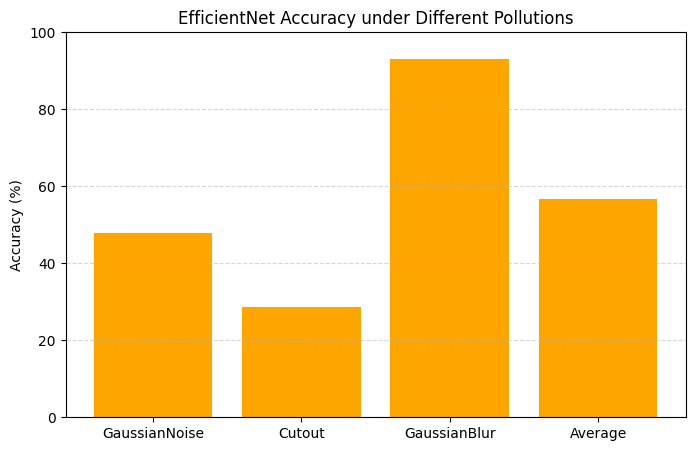

In [62]:
from sklearn.metrics import accuracy_score

def evaluate_accuracy_with_pollution(model, pollution_map):
    model.eval()
    transform = T.Compose([
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225])
    ])
    results = {}

    for mode, class_list in pollution_map.items():
        print(f"\n🧪 Evaluating on pollution: {mode}")
        all_preds, all_labels = [], []

        for cls_name in class_list:
            folder = os.path.join(root_path, cls_name)
            images = [f for f in os.listdir(folder) if f.lower().endswith('.jpg')]
            for fname in images:
                try:
                    img = Image.open(os.path.join(folder, fname)).convert("RGB")
                    img_tensor = transform(img)
                    polluted_tensor = apply_pollution(img_tensor, mode)
                    input_tensor = polluted_tensor.unsqueeze(0).to(device)

                    with torch.no_grad():
                        output = model(input_tensor)
                        pred = output.argmax(dim=1).item()

                    all_preds.append(pred)
                    all_labels.append(class_to_idx[cls_name])
                except Exception as e:
                    print(f"⚠️ Failed {fname}: {e}")
                    continue

        acc = accuracy_score(all_labels, all_preds)
        results[mode] = acc

    return results

acc_dict = evaluate_accuracy_with_pollution(model, pollution_map)

# Visualization
df = pd.DataFrame(list(acc_dict.items()), columns=["Pollution", "Accuracy"])
df["Accuracy (%)"] = df["Accuracy"] * 100
df["Accuracy (%)"] = df["Accuracy (%)"].round(2)
average_acc = sum(acc_dict.values()) / len(acc_dict)
df.loc[len(df.index)] = ["Average", average_acc, average_acc * 100]
display(df)

plt.figure(figsize=(8, 5))
plt.bar(df["Pollution"], df["Accuracy (%)"], color="orange")
plt.title("EfficientNet Accuracy under Different Pollutions")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

